# Guided Motif Search With Annotation Vectors

This tutorial summarizes the findings of the [Matrix Profile V](https://www.cs.ucr.edu/~eamonn/guided-motif-KDD17-new-format-10-pages-v005.pdf) paper and replicates some of the presented case studies.

Time series motifs, as described in the [STUMPY Basics](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html) tutorial, are approximately repeated subsequences within a time series. While the concept of motif discovery is crucial to many fields, the process of motif discovery isn't usually as clean in the real world as we would like it to be and, in most practical uses of motif discovery, we find some motifs to be more desirable than others. For instance, consider the [Amazon Customer Reviews Dataset](https://www.kaggle.com/bittlingmayer/amazonreviews), which contains several million customer reviews from Amazon's website. If we were to combine all of the textual reviews to reveal the most used words on the platform, unsurprisingly, we would find the word "Amazon" to be around the top of the list, probably following a few other more commonly used words such as "the", "and", and "is". While this result is obvious, it is certainly not useful. In order to produce more insightful results, we would need to filter the results to exclude less desirable or "[stop words](https://en.wikipedia.org/wiki/Stop_word)" and make way for the more desirable ones.

When it comes to time series motif discovery, we can use a similar approach as described above. While we can't "filter" a time series, we can favor or "guide" the identification of more interesting motifs and penalize the less interesting ones. This tutorial will provide a brief introduction to **annotation cectors** and explore their roles in **guided motif search**.

## What are Annotation Vectors?

An annotation vector contains real-valued numbers between 0.0 and 1.0 (inclusive) and can be used to distinguish between the important/unimportant subsequences within your time series (with 0 indicating an undesirable subsequence and 1 indicating desirable subsequence). Annotation vectors for a time series can be combined with the matrix profile to form the **corrected matrix profile**, which we can use to identify desirable motifs. The corrected matrix profile can be acquired using the following formula:

$$
\begin{align*}
CMP[i] &= MP[i] + (1 - AV[i]) \times max(MP)
\end{align*}
$$

where $CMP$ is the corrected matrix profile, $MP$ is the original unaltered matrix profile, $AV$ is the annotation vector, and $max(MP)$ is the maximum value of the original matrix profile. Essentially, this formula transforms the original matrix profile by shifting the undesirable distances towards the maximum allowable matrix profile value, $max(MP)$, and thereby eliminating/de-emphasizing those corresponding subsequences as potential motifs.

## Getting Started

Let’s import the packages that we’ll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import stumpy

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

## Hemoglobin Concentration Dataset

Consider the [fNIRS brain imaging dataset](https://zenodo.org/record/5045218/files/hemoglobin.csv?download=1) produced by the UCLA Medical Center. **fNIRS**, or **functional near-infrared specroscopy**, is an optical imaging technique that is used to measure hemoglobin concentrations throughout the brain.

In [2]:
df = pd.read_csv('https://zenodo.org/record/5045218/files/hemoglobin.csv?download=1')
df = df[6000:14000]
df = df.reset_index(drop=True)
df.head()

,Hemoglobin Concentration,Sensor Acceleration
0,4578.0,7861.0
1,4579.0,8008.0
2,4580.0,7959.0
3,4581.0,7959.0
4,4582.0,7959.0


The dataset contains two columns: the hemoglobin concentration and the sensor acceleration data, the latter of which we will get to later. We can visualize the hemoglobin concentration time series first.

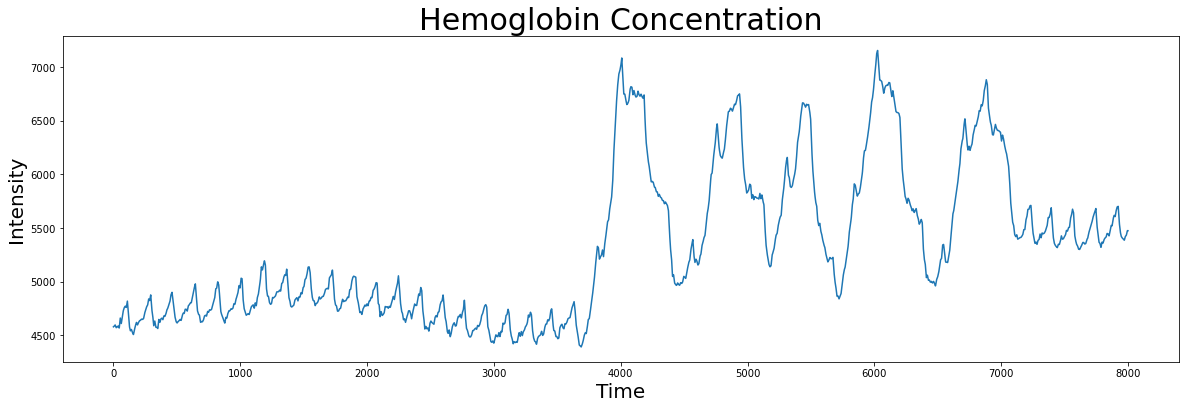

In [3]:
plt.plot(df['Hemoglobin Concentration'])
plt.xlabel('Time', fontsize="20")
plt.ylabel('Intensity', fontsize="20")
plt.title('Hemoglobin Concentration', fontsize="30")
plt.show()

We can use the `stumpy.stump` function to compute the matrix profile for this time series and identify its the index location of its nearest neighbor:

In [4]:
m = 600
mp = stumpy.stump(df['Hemoglobin Concentration'], m)
motif_idx = np.argmin(mp[:, 0])
nn_idx = mp[motif_idx, 1]

Now that we know the index location of the motif/nearest neighbor pair, we can visualize them together:

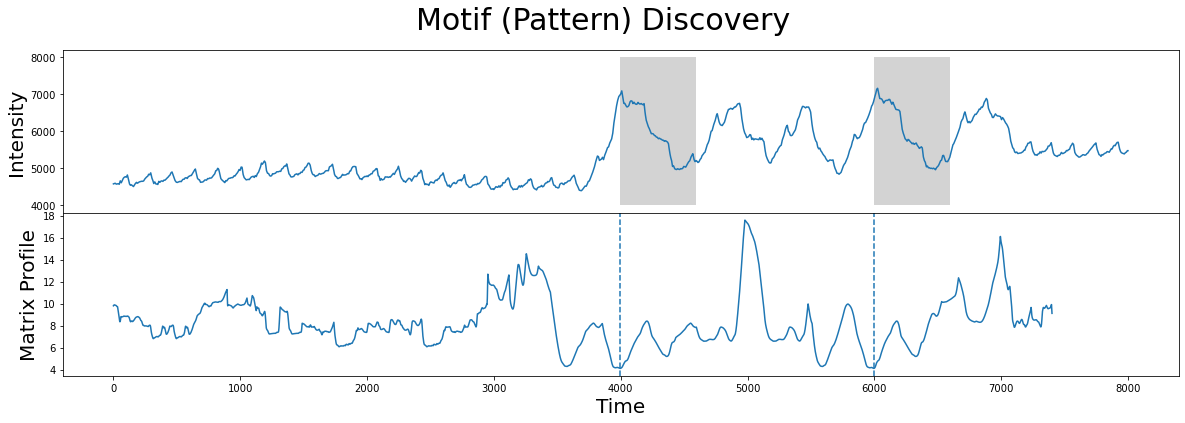

In [5]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(df['Hemoglobin Concentration'])
axs[0].set_ylabel('Intensity', fontsize='20')
rect = Rectangle((motif_idx, 4000), m, 4000, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nn_idx, 4000), m, 4000, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nn_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

plt.show()

Without further context, the results look exactly like what we want. The two subsequences (gray) identified are, in fact, the closest matches.

However, it turns out that the motif/nearest neighbor pair identified above belong to a section of the time series that has no medical significance. What the brain imaging sensor was picking up during this interval was simply the variation in infrared radiation caused by the physical movement of the test subject and not by the hemoglobin concentrations of the brain. This can be verified by visualizing the accompanying sensor acceleration data, which reveals rapid movement between the 4000 and 7000 time points:

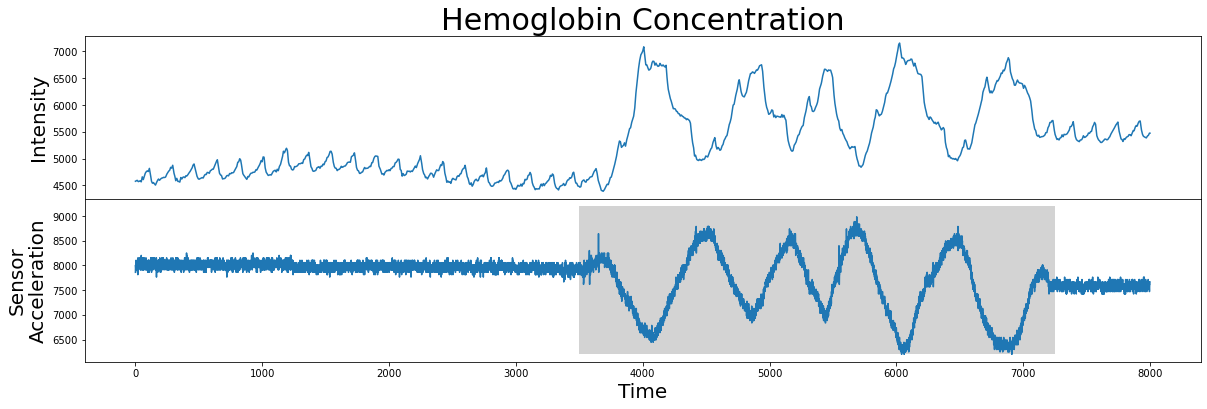

In [6]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(df['Hemoglobin Concentration'])
axs[0].set_ylabel('Intensity', fontsize="20")
axs[0].set_title('Hemoglobin Concentration', fontsize="30")

axs[1].plot(df['Sensor Acceleration'])
axs[1].set_ylabel("Sensor\nAcceleration", fontsize="20")
axs[1].set_xlabel("Time", fontsize="20")
rect = Rectangle((3500, 6200), 3750, 3000, facecolor='lightgrey')
axs[1].add_patch(rect)

plt.show()

So, given this data, how do we rule out this undesirable high variance interval (grey)? In other words, how do we produce an annotation vector from this sensor accelration data so as to keep the desirable regions and remove the undesirable regions?

We can accomplish this by simply computing the sliding variance in the sensor acceleration data:

In [7]:
variance = pd.Series(df['Sensor Acceleration']).rolling(m).var().dropna().values

and then finding intervals with abnormally high local variance (i.e., due to physical movement of the test subject) and setting our annotation vector to zero in those regions. Similarly, if the local variance is less than say, `10000`, then this indicates a reliable region and so we annotate this to a value of 1.0 in our annotation vector:

In [8]:
annotation_vector = (variance < 10000).astype(np.float64)

Note that both the annotation vector and the matrix profile should have the exact same length. Next, let's combine this information and see how it looks: 

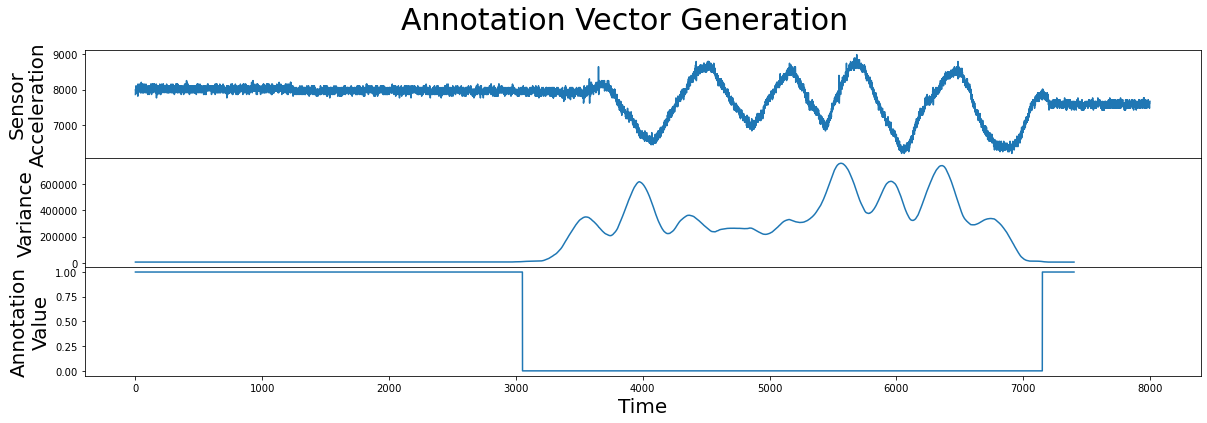

In [9]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle("Annotation Vector Generation", fontsize="30")

axs[0].plot(df["Sensor Acceleration"])
axs[0].set_ylabel("Sensor\nAcceleration", fontsize="20")
axs[1].plot(variance)
axs[1].set_ylabel("Variance", fontsize="20")
axs[2].plot(annotation_vector)
axs[2].set_ylabel("Annotation\nValue", fontsize="20")
axs[2].set_xlabel('Time', fontsize="20")

plt.show()

Great! Now we have an annotation vector that we can use to rule out the regions of physical movement and we can use the formula introduced earlier to compute the corrected matrix profile:

In [10]:
corrected_mp = mp[:, 0] + ((1 - annotation_vector) * np.max(mp[:, 0]))

and we can plot the corrected matrix profile to see how the original matrix profile was altered by the annotation vector: 

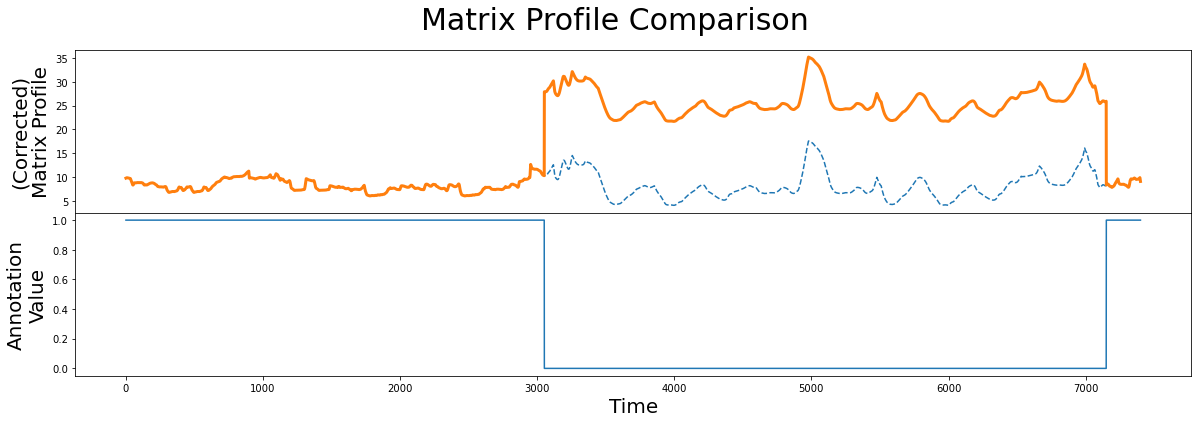

In [11]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Matrix Profile Comparison', fontsize="30")

axs[0].plot(mp[:, 0], linestyle='--')
axs[0].plot(corrected_mp, color='C1', linewidth=3)
axs[0].set_ylabel("(Corrected)\nMatrix Profile", fontsize="20")

axs[1].plot(annotation_vector)
axs[1].set_xlabel("Time", fontsize="20")
axs[1].set_ylabel("Annotation\nValue", fontsize="20")

plt.show()

As we can see, the corrected matrix profile (orange line) is elevated around the region of physical movement. Thanks to the penalized region (solid blue line), the lowest point in the original unaltered matrix profile (dashed line) is no longer in the interval where the test subject is physically moving. Now, we can use this corrected matrix profile inplace of our original matrix profile to locate our top motif as we had done before:

In [12]:
motif_idx = np.argmin(corrected_mp)
nn_idx = mp[motif_idx, 1]

and plot the results:

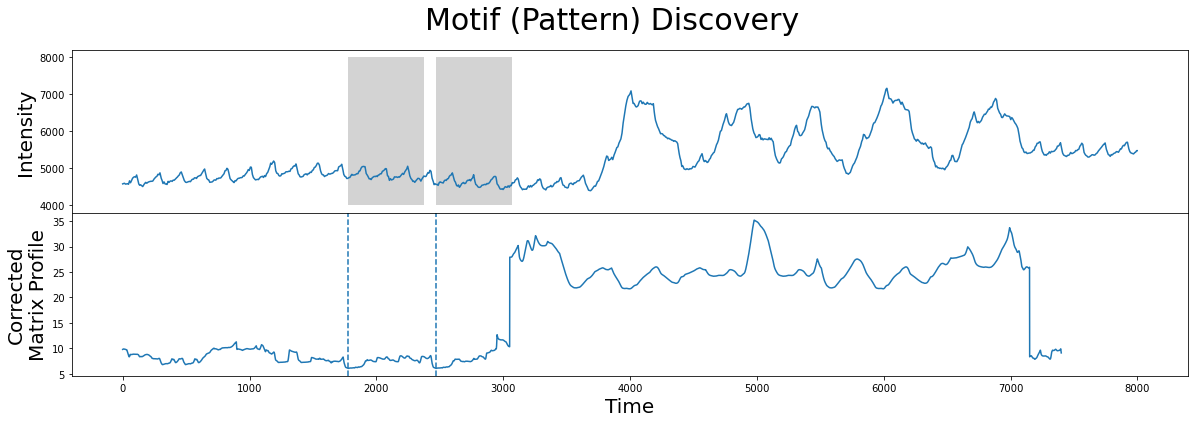

In [13]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(df['Hemoglobin Concentration'])
axs[0].set_ylabel('Intensity', fontsize='20')
rect = Rectangle((motif_idx, 4000), m, 4000, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nn_idx, 4000), m, 4000, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Corrected\nMatrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nn_idx, linestyle="dashed")
axs[1].plot(corrected_mp)
plt.show()

plt.show()

As we can see, the motif/nearest neighbor pair (grey) have moved towards the left near the smaller peaks that correspond to more desirable data and, thus, we have successfully excluded the region of physical movement from our motif search!

In the above example, we produced an annotation vector that either completely neglects our undesirable regions. However, there are times when we may not want to completely remove a region from the motif search, but merely to "discourage/de-emphasize" it. The next example explores this case.

## Electrooculography Dataset

Consider the [EOG dataset](https://zenodo.org/record/5045252/files/eog.csv?download=1) containing electric potential data of the left-eye, sampled at 50 Hz. **EOG**, or **Electrooculography**, is a technique used for measuring the potential that exists between the front and back of the human eye. We can download and visualize the data to better understand its trend:

In [14]:
df = pd.read_csv('https://zenodo.org/record/5045252/files/eog.csv?download=1')
df.head()

,Electric Potential
0,-0.980
1,2.941
2,2.941
3,2.941
4,2.941


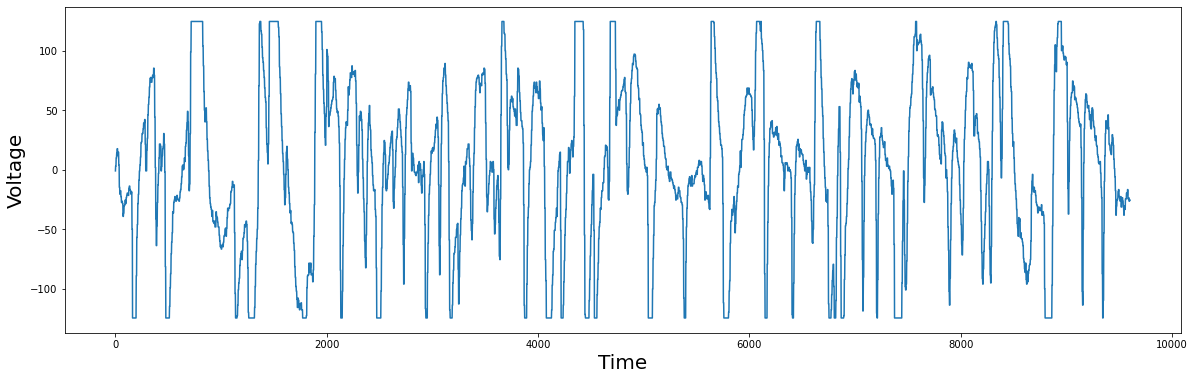

In [15]:
plt.plot(df['Electric Potential'])
plt.xlabel('Time', fontsize="20")
plt.ylabel('Voltage', fontsize="20")

plt.show()

You should notice that some points in the plot have flat tops or bottoms. Medically, this is not reflecting reality. The flat tops and bottoms are simply clipping regions, since the measured value exceeded the measurement range of a floating point number. Nonetheless, we can blindly compute the matrix profile and locate the best motif:

In [16]:
m = 450
mp = stumpy.stump(df['Electric Potential'], m)
motif_idx = np.argmin(mp[:, 0])
nn_idx = mp[motif_idx, 1]

and visualize the results:

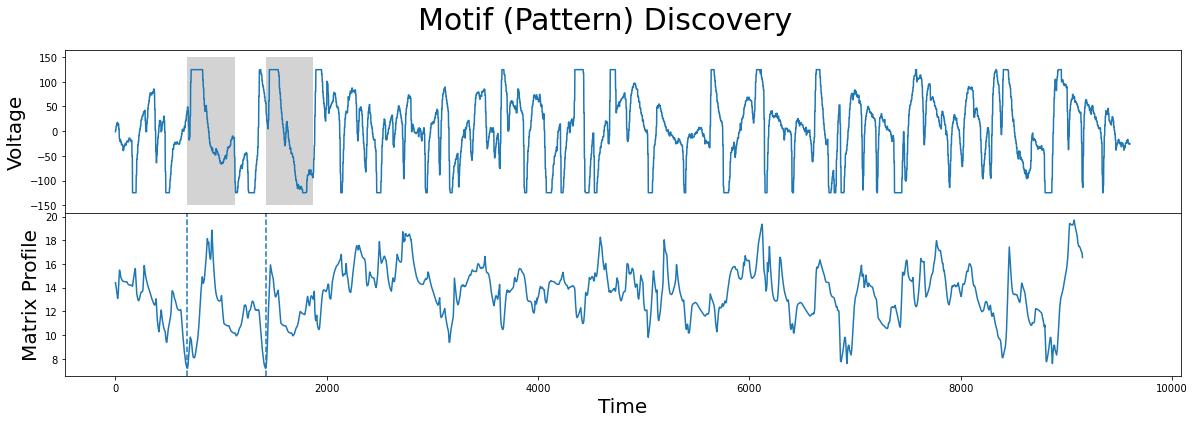

In [17]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(df['Electric Potential'])
axs[0].set_ylabel('Voltage', fontsize='20')
rect = Rectangle((motif_idx, -150), m, 300, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nn_idx, -150), m, 300, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nn_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

plt.show()

Unsurprisingly, the motif/nearest-neighbor pair contain the biggest flat top of the time series. This makes sense, since the distance between two flat tops is very low.

Of course, because the flat tops or bottoms are areas where the actual value of the electric potential is unclear, we want to make this a less desirable motif. But the difference between the previous hemoglobin example and this current one, is that we don't want to completely dismiss these clipping regions. Rather, we want to penalize them only slightly. We do this by constructing an annotation vector that is real-valued, as opposed to the previous example where it was restricted to only be either 0 or 1. So, for every subsequence, we count the number of values that are equal to the global minimum or maximum. The higher the count is, the lower we set the annotation vector value for that subsequence, and vice versa:

In [18]:
global_min = df["Electric Potential"].min()
global_max = df["Electric Potential"].max()
count_minmax = lambda x: np.count_nonzero(x == global_max) + np.count_nonzero(x == global_min)
annotation_vector = df["Electric Potential"].rolling(m).apply(count_minmax).dropna().values
annotation_vector = 1 - (annotation_vector - np.min(annotation_vector)) / np.max(annotation_vector)

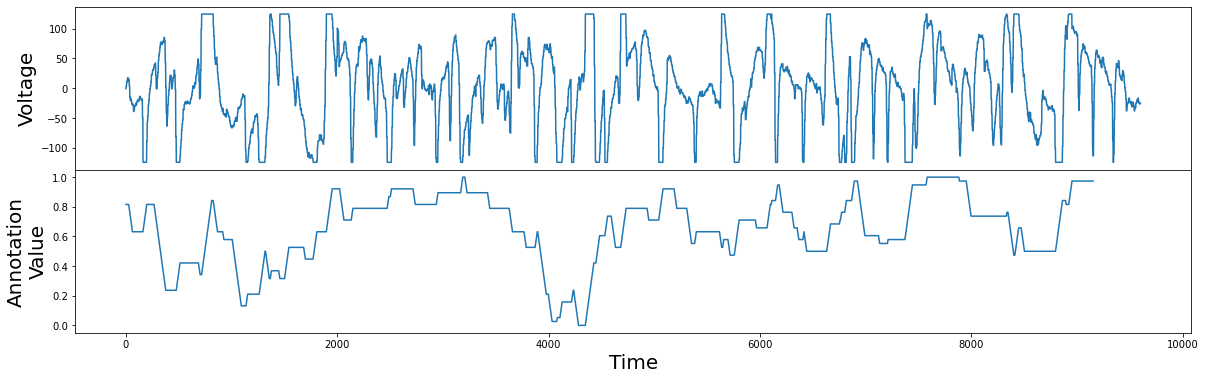

In [19]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(df["Electric Potential"])
axs[0].set_ylabel("Voltage", fontsize="20")
axs[1].plot(annotation_vector)
axs[1].set_ylabel("Annotation\nValue", fontsize="20")
axs[1].set_xlabel('Time', fontsize="20")
plt.show()

Now we have an annotation vector that is lower at subsequences that contain flat tops or bottoms, and higher where there are no flat tops or bottoms. In contrast to the annotation vector generated for the hemoglobin concentrations example, this annotation vector can take any real-valued number between 0 and 1. We can now proceed as before and use this annotation vector to generate the corrected matrix profile:

In [20]:
corrected_mp = mp[:, 0] + ((1 - annotation_vector) * np.max(mp[:, 0]))

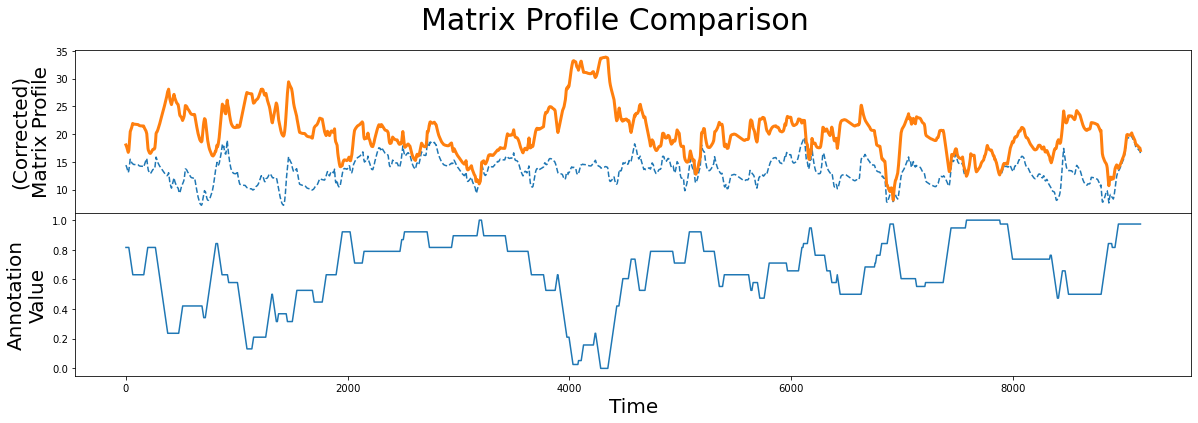

In [21]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Matrix Profile Comparison', fontsize="30")

axs[0].plot(mp[:, 0], linestyle='--')
axs[0].plot(corrected_mp, color='C1', linewidth=3)
axs[0].set_ylabel("(Corrected)\nMatrix Profile", fontsize="20")

axs[1].plot(annotation_vector)
axs[1].set_xlabel("Time", fontsize="20")
axs[1].set_ylabel("Annotation\nValue", fontsize="20")

plt.show()

When we compare the original unaltered matrix profile (dashed line) and the corrected matrix profile (orange line), we clearly see that the subsequences with the lowest matrix profile value has changed. Now we are ready to compute the best motif again using the corrected matrix profile:

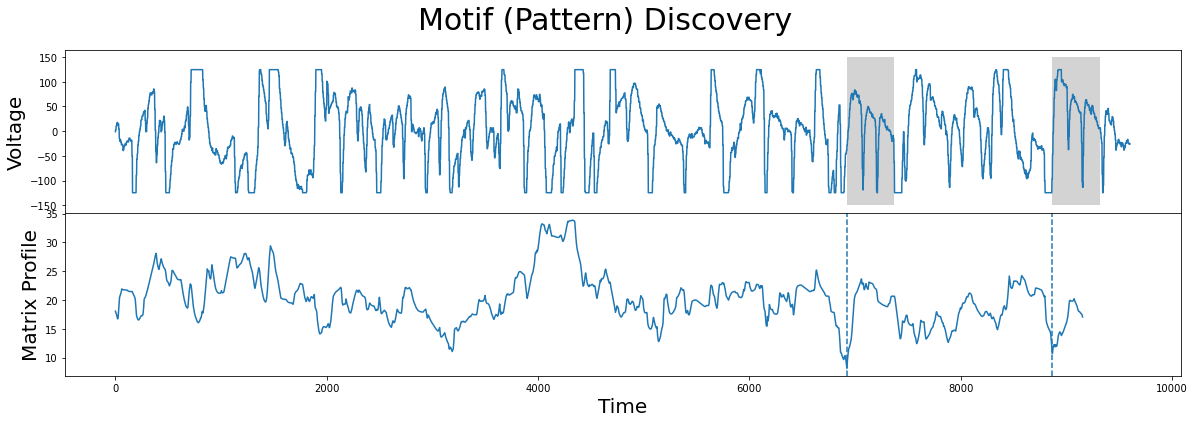

In [22]:
motif_idx = np.argmin(corrected_mp)
nn_idx = mp[motif_idx, 1]

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(df['Electric Potential'])
axs[0].set_ylabel('Voltage', fontsize='20')
rect = Rectangle((motif_idx, -150), m, 300, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nn_idx, -150), m, 300, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nn_idx, linestyle="dashed")
axs[1].plot(corrected_mp)
plt.show()

plt.show()

As we can see, the new motifs (grey) are no longer at flat top or flat bottom regions and, once again, we've successfully guided our motif search to find the more interesting motifs.

## Summary

And that's it! You've now learned the basics of guided motif search with annotation vectors and you can now leverage this simple approach and use it in your own projects. Happy coding!

## Resources

[Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf)

[STUMPY Basics](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html)

[Matrix Profile V](https://www.cs.ucr.edu/~eamonn/guided-motif-KDD17-new-format-10-pages-v005.pdf)